In [1]:
%load_ext autoreload
%autoreload 2
# 基本使用
from utils.chain_split_utils import extract_monomers

In [8]:
from rdkit import Chem
from utils.chain_split_utils import extract_save_monomers,extract_submol_by_atoms
from utils.chain_split_utils import compose_monomers_from_local_monomers,remove_star_atoms
from utils.chain_split_utils import extract_monomers,save_to_sdf,extract_rigid_from_monomers
from utils.chain_split_utils import extract_save_monomers,compose_monomers_from_local_monomers,extract_monomers,save_to_sdf,extract_rigid_from_monomers,remove_star_atoms
from utils.conf_utils import merge_monomer
from utils.chain_simulate_utils import HomoChainBuilder
import os
psmiles = "[*]CCON[*]"
hcb = HomoChainBuilder(lmps_exec='/data/yifei/lammps-22Jul2025/src/lmp_mpi',work_dir='./lmp_dir/work_dir',
temp_dir='./lmp_dir/temp_dir')
# homopoly_init = hcb.create_mol(psmiles,n_repeat=5,random_walk=False)
key_point_list, processed_mol, processed_smi= remove_star_atoms(psmiles)
homopoly_relaxed,homopoly_init = hcb.fromSmiles(psmiles,n_repeat=5,save_dir='./lmp_dir/save_dir',random_walk=True,
args_dict={'temp':298,'high_temp':600,'prev_nvt_steps':60000,'cool_steps':500000,'final_nvt_steps':1000000,'time_step_low':0.5,'time_step':2.0,'box_length':150.0,'comm_cutoff':12.0})


RadonPy info: Psi4 RESP charge calculation is running...
RadonPy info: Normal termination of psi4 RESP charge calculation. Elapsed time = 0:00:07.262567
RadonPy info: Psi4 RESP charge calculation is running...
RadonPy info: Normal termination of psi4 RESP charge calculation. Elapsed time = 0:00:00.844304
RadonPy info: Psi4 RESP charge calculation is running...
RadonPy info: Normal termination of psi4 RESP charge calculation. Elapsed time = 0:00:01.079974
RadonPy info: Start polymerize_rw.
RadonPy info: Start terminate_rw.
RadonPy info: Stage[minimize] running...
RadonPy warning: OPENMP package is not available. Parallel number of OPENMP is changed to zero.
RadonPy info: Stage[pre_nvt @300K] running...
RadonPy warning: OPENMP package is not available. Parallel number of OPENMP is changed to zero.
RadonPy info: Stage[hot @ 600K] running...
RadonPy warning: OPENMP package is not available. Parallel number of OPENMP is changed to zero.
RadonPy info: Stage[cool high->target] running...
Rado

In [3]:
import py3Dmol

def show_mol_3d(mol, width=400, height=300, style='stick', background='0xeeeeee'):
    mb = Chem.MolToMolBlock(mol)
    view = py3Dmol.view(width=width, height=height)
    view.addModel(mb, 'mol')
    view.setStyle({style: {}})
    view.setBackgroundColor(background)
    view.zoomTo()
    return view

In [10]:
homopoly_relaxed = Chem.RemoveAllHs(homopoly_relaxed)
homopoly_init = Chem.RemoveAllHs(homopoly_init)
local_monomers,R_list,t_list = extract_save_monomers(mol=homopoly_relaxed,psmiles=psmiles,save_dir='./output_dir')

In [7]:

print("可视化 homopoly_relaxed：")
view_relaxed = show_mol_3d(homopoly_relaxed)
view_relaxed.show()

print("可视化 homopoly_init：")
view_init = show_mol_3d(homopoly_init)
view_init.show()
print(Chem.RemoveHs(homopoly_init).GetNumAtoms())

可视化 homopoly_relaxed：


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

可视化 homopoly_init：


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

22


In [11]:
# 将 homopoly_relaxed 和 homopoly_init 分别保存为 SDF 文件
from rdkit import Chem

save_dir = os.path.join(os.getcwd(), "output_dir")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

relaxed_sdf_path = os.path.join(save_dir, "homopoly_relaxed.sdf")
init_sdf_path = os.path.join(save_dir, "homopoly_init.sdf")

writer_relaxed = Chem.SDWriter(relaxed_sdf_path)
writer_relaxed.write(homopoly_relaxed)
writer_relaxed.close()

writer_init = Chem.SDWriter(init_sdf_path)
writer_init.write(homopoly_init)
writer_init.close()

print(f"已保存 homopoly_relaxed 到 {relaxed_sdf_path}")
print(f"已保存 homopoly_init 到 {init_sdf_path}")


已保存 homopoly_relaxed 到 /data/yifei/2025.08/chain_generator/output_dir/homopoly_relaxed.sdf
已保存 homopoly_init 到 /data/yifei/2025.08/chain_generator/output_dir/homopoly_init.sdf


RMSD矩阵：
[[0.         0.74868822 0.29370565 0.48255938 0.56252724]
 [0.74868822 0.         0.67553624 0.93245348 0.75031517]
 [0.29370565 0.67553624 0.         0.54187465 0.58382953]
 [0.48255938 0.93245348 0.54187465 0.         0.51537409]
 [0.56252724 0.75031517 0.58382953 0.51537409 0.        ]]


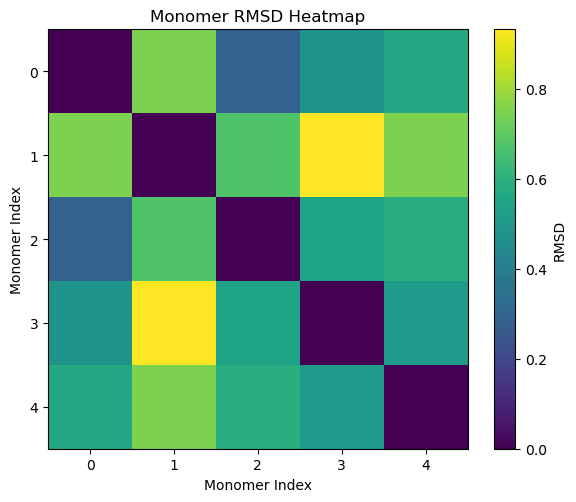

In [12]:
# INSERT_YOUR_CODE
import numpy as np
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, rdMolAlign

# 计算所有monomer之间的RMSD矩阵
n = len(local_monomers)
rmsd_matrix = np.zeros((n, n))

# 先为每个分子生成3D构象（如果没有的话）
# for i, mol in enumerate(monomer_list):
#     if mol.GetNumConformers() == 0:
#         AllChem.EmbedMolecule(mol, AllChem.ETKDG())
#         AllChem.UFFOptimizeMolecule(mol)

for i in range(n):
    for j in range(n):
        if i == j:
            rmsd_matrix[i, j] = 0.0
        elif i < j:
            # 对齐并计算RMSD
            try:
                rmsd = rdMolAlign.GetBestRMS(local_monomers[i], local_monomers[j])
            except Exception as e:
                rmsd = np.nan
            rmsd_matrix[i, j] = rmsd
            rmsd_matrix[j, i] = rmsd  # 对称

print("RMSD矩阵：")
print(rmsd_matrix)

# 可视化RMSD矩阵为热力图
plt.figure(figsize=(6, 5))
im = plt.imshow(rmsd_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(im, label='RMSD')
plt.title("Monomer RMSD Heatmap")
plt.xlabel("Monomer Index")
plt.ylabel("Monomer Index")
plt.xticks(range(n), [f"{i}" for i in range(n)])
plt.yticks(range(n), [f"{i}" for i in range(n)])
plt.tight_layout()
plt.show()
